# SYDE 556/750: Simulating Neurobiological Systems


## Lecture 10: Learning

## Learning

- What do we mean by learning?
    - When we use an integrator to keep track of location, is that learning?
    - What about the learning used to complete a pattern in the Raven's Progressive Matrices task?
    - Neither of these require any connection weights to change in the model
    - But both allow future performance to be affected by past performance
    - I suggest the term 'adaptation' to capture all such future-affected-by-past phenomena

- So, we'll stick with a simple definition of learning
    - Changing connection weights between groups of neurons

- Why might we want to change connection weights?
- This is what traditional neural network approaches do
    - Change connection weights until it performs the desired task
    - Once it's doing the task, stop changing the weights
- But we have a method for just solving for the optimal connection weights
    - So why bother learning?

### Why learning might be useful

- We might not know the function at the beginning of the task
    - Example: a creature explores its environment and learns that eating red objects is bad, but eating green objects is good
        - what are the inputs and outputs here?
- The desired function might change
    - Example: an ensemble whose input is a desired hand position, but the output is the muscle tension (or joint angles) needed to get there
        - why would this change?
- The optimal weights we solve for might not be optimal
    - How could they not be optimal?
    - What assumptions are we making?

### The simplest approach

- What's the easiest way to deal with this, given what we know?
- If we need new decoders
    - Let's solve for them while the model's running
    - Gather data to build up our $\Gamma$ and $\Upsilon$ matrices


- Example: eating red but not green objects
    - Decoder from state to $Q$ value (utility of action) for eating
    - State is some high-dimensional vector that includes the colour of what we're looking for
         - And probably some other things, like whether it's small enough to be eaten
    - Initially doesn't use colour to get output
    - But we might experience a few bad outcomes after red, and good after green
    - These become new $x$ samples, with corresponding $f(x)$ outputs
    - Gather a few, recompute decoder
        - Could even do this after every timestep
- Example: converting hand position to muscle commands
    - Send random signals to muscles
    - Observe hand position
    - Use that to train decoders
- Example: going from optimal to even more optimal
    - As the model runs, we gather $x$ values  
    - Recompute decoder for those $x$ values
    

### What's wrong with this approach

- Feels like cheating
- Why?
- Two kinds of problems:
    - Not biologically realistic
        - How are neurons supposed to do all this?
        - store data
        - solve decoders
        - timing
    - Computationally expensive
        - Even if we're not worried about realism

## Traditional neural networks

- Traditionally, learning is the main method of constructing a model network
- Usually incremental learning (gradient descent)
    - As you get examples, shift the connection weights slightly based on that example
    - Don't have to consider all the data when making an update
- Example: Perceptron learning (1957)
    - $\Delta w_j = \alpha(y_d - y)x_i$

<img src="files/lecture_learning/perceptron.png">

- Problems with perceptron
    - Can't do all possible functions
    - Effectively just linear functions of $x$ (with a threshold; i.e. a linear classifier)
    - Is that a problem (X)OR not?
    


## Backprop and the NEF

- How are nonlinear functions included?
    - Multiple layers
    
<img src="files/lecture_learning/backprop.png" width="600">
    
- But now a new rule is needed
    - Standard answer: backprop
    - Same as perceptron for first (output) layer
    - Backprop adds: Estimate correct "hidden layer" input, and repeat


- What would this be in NEF terms?
- Remember that we're already fine with linear decoding
    - Encoders (and $\alpha$ and $J^{bias}$) are input layer of weights, decoders are output layer
    - Note that in the NEF, we combine many of these layers together
- We can just use the standard perceptron rule for decoders
    - As long as there are lots of neurons, and we've initialized them well with the desired intercepts, maximum rates, and encoders we should be able to decode lots of functions
    - So, what might backprop add to that?
        - Think about encoders

## Biologically realistic perceptron learning

-  [(MacNeil & Eliasmith, 2011)](http://compneuro.uwaterloo.ca/publications/macneil2011.html)  derive a simple, plausible learning rule starting with a delta rule
- $E = 1/2 \int (x-\hat{x})^2 dx$
- $\delta E/\delta d_i = (x-\hat{x})a_i$ (as usual for finding decoders)
- So, to move down the gradient:
    - $\Delta d_i = -\kappa (x - \hat{x})a_i$ (NEF notation)
    - $\Delta d_i = \kappa (y_d - y)a_i$ (the standard perceptron/delta rule)


- How do we make it realistic?
- Decoders don't exist in the brain
    - Need weights
- The NEF tells us:
    - $\omega_{ij} = \alpha_j d_i \cdot e_j$
    - $\Delta \omega_{ij} = \alpha_j \kappa (y_d - y)a_i \cdot e_j$
- Let's write $(y_d - y)$ as $E$ (for error)
    - $\Delta \omega_{ij} = \alpha_j \kappa a_i E \cdot e_j$
    - $\Delta \omega_{ij} = \kappa a_i (\alpha_j E \cdot e_j)$
- What's $\alpha_j E \cdot e_j$?
    - That's the current that this neuron would get if it had $E$ as an input
    - But we don't want this current to drive the neuron
    - Rather, we want it to change the weight
    - It's a *modulatory* input


- This is the "Prescribed Error Sensitivity" PES rule
    - Any model in the NEF could use this instead of computing decoders
    - Requires some other neural group computing the error $E$
    - Used in Spaun for Q-value learning (reinforcement task)
    - Can even be used to learn circular convolution
        - Only demonstrated up to 3 dimensions in [(Bekolay et al, 2013)](http://compneuro.uwaterloo.ca/publications/bekolay2013.html)
        - Why not more? Patience.


- Is this realistic?
    - Local information only
    - Need an error signal
        - Does it look like anything like this happens in the brain?
        - Yes
            - Retinal slip error is computed in oculomotor system
            - Dopamine seems to act as prediction error 
    - Weight changes proportional to pre-synaptic activity and post-synaptic activity (Hebbian rule)

In [1]:
#From the learning examples in Nengo - a Communication Channel
%pylab inline
import nengo
from nengo.processes import WhiteSignal

model = nengo.Network('Learn a Communication Channel')
with model:
    stim = nengo.Node(output=WhiteSignal(10, high=5, rms=0.5), size_out=2)
    
    pre = nengo.Ensemble(60, dimensions=2)
    post = nengo.Ensemble(60, dimensions=2)
    
    nengo.Connection(stim, pre)
    conn = nengo.Connection(pre, post, function=lambda x: np.random.random(2))
    
    inp_p = nengo.Probe(stim)
    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

sim = nengo.Simulator(model)
#sim.run(10.0)    

Populating the interactive namespace from numpy and matplotlib


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [9]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'configs/pre_learn.py.cfg')

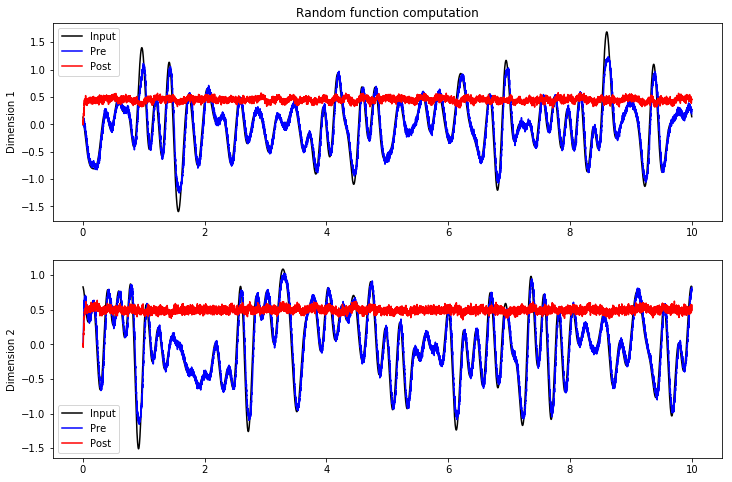

In [3]:
t=sim.trange()

figure(figsize=(12, 8))
subplot(2, 1, 1)
plot(t, sim.data[inp_p].T[0], c='k', label='Input')
plot(t, sim.data[pre_p].T[0], c='b', label='Pre')
plot(t, sim.data[post_p].T[0], c='r', label='Post')
ylabel("Dimension 1")
legend(loc='best')
title('Random function computation')
    
subplot(2, 1, 2)
plot(t, sim.data[inp_p].T[1], c='k', label='Input')
plot(t, sim.data[pre_p].T[1], c='b', label='Pre')
plot(t, sim.data[post_p].T[1], c='r', label='Post')
ylabel("Dimension 2")
legend(loc='best');

In [2]:
#Now learn
with model:
    error = nengo.Ensemble(60, dimensions=2)
    error_p = nengo.Probe(error, synapse=0.03)
    
    # Error = actual - target = post - pre
    nengo.Connection(post, error)
    nengo.Connection(pre, error, transform=-1)
    
    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()
    
    # Connect the error into the learning rule
    learn_conn = nengo.Connection(error, conn.learning_rule) 

sim = nengo.Simulator(model)
sim.run(10.0)     

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [3]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'configs/simple_learn.py.cfg')

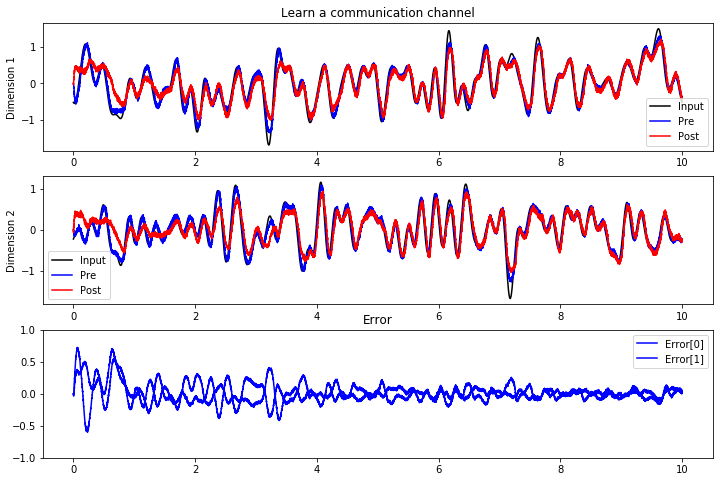

In [7]:
t=sim.trange()

figure(figsize=(12, 8))
subplot(3, 1, 1)
plot(t, sim.data[inp_p].T[0], c='k', label='Input')
plot(t, sim.data[pre_p].T[0], c='b', label='Pre')
plot(t, sim.data[post_p].T[0], c='r', label='Post')
ylabel("Dimension 1")
legend(loc='best')
title('Learn a communication channel')
    
subplot(3, 1, 2)
plot(t, sim.data[inp_p].T[1], c='k', label='Input')
plot(t, sim.data[pre_p].T[1], c='b', label='Pre')
plot(t, sim.data[post_p].T[1], c='r', label='Post')
ylabel("Dimension 2")
legend(loc='best');

subplot(3, 1, 3)
plot(sim.trange(), sim.data[error_p], c='b')
ylim(-1, 1)
legend(("Error[0]", "Error[1]"), loc='best');
title('Error')

In [4]:
#Turning learning on and off to test generalization
def inhibit(t):
    return 2.0 if t > 10.0 else 0.0

with model:
    inhib = nengo.Node(inhibit)
    inhib_conn = nengo.Connection(inhib, error.neurons, transform=[[-1]] * error.n_neurons)
    
sim = nengo.Simulator(model)
#sim.run(16.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [5]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'configs/control_learn.py.cfg')

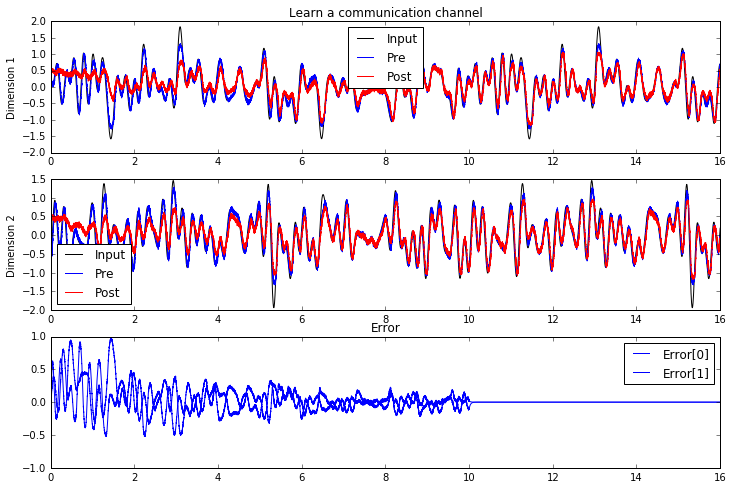

In [9]:
t=sim.trange()

figure(figsize=(12, 8))
subplot(3, 1, 1)
plot(t, sim.data[inp_p].T[0], c='k', label='Input')
plot(t, sim.data[pre_p].T[0], c='b', label='Pre')
plot(t, sim.data[post_p].T[0], c='r', label='Post')
ylabel("Dimension 1")
legend(loc='best')
title('Learn a communication channel')
    
subplot(3, 1, 2)
plot(t, sim.data[inp_p].T[1], c='k', label='Input')
plot(t, sim.data[pre_p].T[1], c='b', label='Pre')
plot(t, sim.data[post_p].T[1], c='r', label='Post')
ylabel("Dimension 2")
legend(loc='best');

subplot(3, 1, 3)
plot(sim.trange(), sim.data[error_p], c='b')
ylim(-1, 1)
legend(("Error[0]", "Error[1]"), loc='best');
title('Error')

In [6]:
#Compute a nonlinear functions
#model.connections.remove(err_fcn) #uncomment to try other fcns
#del err_fcn
model.connections.remove(inhib_conn)
del inhib_conn
model.nodes.remove(inhib)
model.connections.remove(learn_conn)
del learn_conn

def nonlinear(x):
    return x[0]*x[0], x[1]*x[1]

with model:
    err_fcn = nengo.Connection(pre, error, function=nonlinear, transform=-1)
    
    conn.learning_rule_type = nengo.PES(learning_rate=1e-4)
    # Connect the error into the learning rule
    learn_conn = nengo.Connection(error, conn.learning_rule)    
    
sim = nengo.Simulator(model)
#sim.run(26.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [7]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'configs/square_learn.py.cfg')

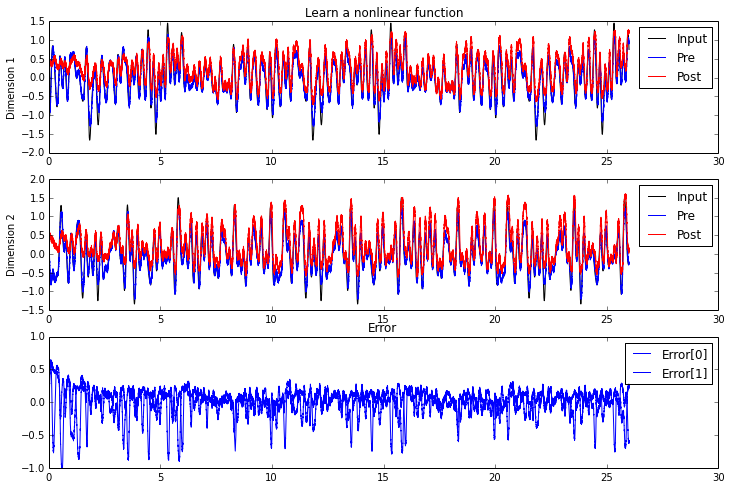

In [28]:
t=sim.trange()

figure(figsize=(12, 8))
subplot(3, 1, 1)
plot(t, sim.data[inp_p].T[0], c='k', label='Input')
plot(t, sim.data[pre_p].T[0], c='b', label='Pre')
plot(t, sim.data[post_p].T[0], c='r', label='Post')
ylabel("Dimension 1")
legend(loc='best')
title('Learn a nonlinear function')
    
subplot(3, 1, 2)
plot(t, sim.data[inp_p].T[1], c='k', label='Input')
plot(t, sim.data[pre_p].T[1], c='b', label='Pre')
plot(t, sim.data[post_p].T[1], c='r', label='Post')
ylabel("Dimension 2")
legend(loc='best');

subplot(3, 1, 3)
plot(sim.trange(), sim.data[error_p], c='b')
ylim(-1, 1)
legend(("Error[0]", "Error[1]"), loc='best');
title('Error')

- This rule can be used to learn any nonlinear vector function
- It does as well, or better, than the typical NEF decoder optimization
- It's a 'spike-based' rule... meaning it works in a spiking network
- It has been used for 'constant supervision' as well as 'reinforcement learning' (occasional supervision) tasks (Spaun uses it for the RL task)
- It moves the focus of learning research from weight changes or 'learning rules' to error signals
- Backprop is one way of propagating error signals (unfortunately not bio-plausible)
- Pretty much ignores encoders (which should maybe be about capturing all the incoming information, so as to compute any function over that information... though they can be optimized for a given fcn as well)

## Applications of PES
### Classical conditioning

- Classical or Pavlovian conditioning uses an unconditioned stimuli (US) (meat for a dog) that ellicits an unconditioned response (UR) (salivating) to cause a conditioned response (CR) (salivating after learning) to be ellicited by a conditioned stimulus (CS) (ringing a bell).

- The best known model of this is the Rescorla-Wagner model that states:

$\Delta V_x = \alpha (\lambda - \sum_x V)$ 

where $V_x$ is the value of conditioned stimulus $x$, $\alpha$ is a learning rate and salience parameter, $\lambda$ is the max value (usually 1).  

- In the model below there is only 1 element in $\sum V$ (or you can assume there is little association between other stimuli and the US). The difference in brackets is like a reward prediction error.

In this model: 
- There are three different US that are provided
to the model, one after the other.  
- Each has a different hardwired
UR.
- There is also a CS provided (a different
one for each US)  
- The model attempts to learn to trigger the correct
CR in response to the CS.  
- After learning, the CR should start to respond *before* the corresponding UR.

In [8]:
import nengo
import numpy as np

D = 3
N = D*50

def us_stim(t):
    # cycle through the three US
    t = t % 3
    if 0.9 < t< 1: return [1, 0, 0]
    if 1.9 < t< 2: return [0, 1, 0]
    if 2.9 < t< 3: return [0, 0, 1]
    return [0, 0, 0]

def cs_stim(t):
    # cycle through the three CS
    t = t % 3
    if 0.7 < t< 1: return [0.7, 0, 0.5]
    if 1.7 < t< 2: return [0.6, 0.7, 0.8]
    if 2.7 < t< 3: return [0, 1, 0]
    return [0, 0, 0]

model = nengo.Network(label="Classical Conditioning")
with model:
    us_stim = nengo.Node(us_stim)
    cs_stim = nengo.Node(cs_stim)

    us = nengo.Ensemble(N, D)
    cs = nengo.Ensemble(N*2, D*2)

    nengo.Connection(us_stim, us[:D])
    nengo.Connection(cs_stim, cs[:D])
    nengo.Connection(cs[:D], cs[D:], synapse=0.2)

    ur = nengo.Ensemble(N, D)
    nengo.Connection(us, ur)
    
    cr = nengo.Ensemble(N, D)
    learn_conn = nengo.Connection(cs, cr, function=lambda x: [0]*D)
    learn_conn.learning_rule_type = nengo.PES(learning_rate=3e-4)

    error = nengo.Ensemble(N, D)
    nengo.Connection(error, learn_conn.learning_rule)
    nengo.Connection(ur, error, transform=-1)
    nengo.Connection(cr, error, transform=1, synapse=0.1)

    stop_learn = nengo.Node([0])
    nengo.Connection(stop_learn, error.neurons, transform=-10*np.ones((N, 1)))

In [9]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'configs/learning2-conditioning.py.cfg')

### Cortical Consolidation

- There is evidence that when you first learn a skill, it takes a lot of effort and you tend to perform fairly slowly.  
- We would think of this as requiring a lot of intervention from the basal ganglia in selecting actions.  
- As you get better at the skill you become much faster, and BG is used less because cortex 'takes over' cental aspects of that skill, consolidating it into cortico-cortical connections.  
- The next model shows a toy version of this kind of behaviour.



In this model:
- there is a slow mapping from pre->wm->target (because of long synaptic time constants) 
- there is a fast, direct connection from pre->post 
- the fast connection is trained using the error signal from the slow system
- the fast system learns to produce the correct output before the slow system
- if you change the 'context' the fast system will learn the output
- there is a more complete model that uses this kind of thing (but with BG) in [Aubin et al., 2016](http://compneuro.uwaterloo.ca/publications/aubin2016a.html)

In [16]:
import nengo
import numpy as np

tau_slow = 0.2

model = nengo.Network("Cortical Consolidation")
with model:
    pre_value = nengo.Node(lambda t: np.sin(t))
    
    pre = nengo.Ensemble(100, 1)
    post = nengo.Ensemble(100, 1)
    target = nengo.Ensemble(100, 1)
    nengo.Connection(pre_value, pre)

    conn = nengo.Connection(pre, post, function=lambda x: np.random.random(),
                learning_rule_type=nengo.PES())
    
    wm = nengo.Ensemble(300, 2, radius=1.4)
    context = nengo.Node(1)
    nengo.Connection(context, wm[1])
    nengo.Connection(pre, wm[0], synapse=tau_slow)
    
    nengo.Connection(wm, target, synapse=tau_slow, 
                     function=lambda x: x[0]*x[1])
                     
    error = nengo.Ensemble(n_neurons=100, dimensions=1)
    nengo.Connection(post, error, synapse=tau_slow*2, transform=1) #Delay the fast connection so they line up
    nengo.Connection(target, error, transform=-1)
    
    nengo.Connection(error, conn.learning_rule)

    stop_learn = nengo.Node([0])
    nengo.Connection(stop_learn, error.neurons, transform=-10*np.ones((100,1)))
    
    both = nengo.Node(None, size_in=2) #For plotting
    nengo.Connection(post, both[0], synapse=None)
    nengo.Connection(target, both[1], synapse=None)

In [17]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'configs/learning3-consolidation.py.cfg')

### Reinforcement Learning - Do evaluations!!!!  Brain Day!

- As mentioned in the last lecture, RL is a useful way to think about action selection.  
- You have a set of actions and a set of states, and you figure out the value of each action in each state, letting you construct a big table $Q(s,a)$ which you can use to pick good actions.  
- RL figures out what those values are through trial and error. (This is SARSA.)  

$\Delta Q(s,a) = \alpha (R + \gamma Q_{predicted} - Q_{old})$  where $R$ is reward, $\alpha$ is a learning rate and $\gamma$ is a discount factor.



In the model:
- the agent has three actions (go forward, turn left, and turn right)
- its only sense are five range finders (radar)  
- initially it should always go forward
- it gets reward proportial to its forward speed, but a large negative reward for hitting walls
- the error signal is simply the difference between the computed utility and the instantaneous reward
- $\Delta Q(s,a) = \alpha (R - Q_{current})$
- this error will only be applied to whatever action is currently being chosen, which means it cannot learn to do actions that will lead to *future* rewards

In [ ]:
import grid

mymap="""
#########
#       #
#       #
#   ##  #
#   ##  #
#       #
#########

"""

class Cell(grid.Cell):
    def color(self):
        return 'black' if self.wall else None
    def load(self, char):
        if char == '#':
            self.wall = True

world = grid.World(Cell, map=mymap, directions=4)

body = grid.ContinuousAgent()
world.add(body, x=1, y=3, dir=2)

import nengo
import numpy as np    

def move(t, x):
    speed, rotation = x
    dt = 0.001
    max_speed = 20.0
    max_rotate = 10.0
    body.turn(rotation * dt * max_rotate)
    success = body.go_forward(speed * dt * max_speed)
    if not success: #Hit a wall
        return -1
    else:
        return speed

model = nengo.Network("Simple RL", seed=2)
with model:
    env = grid.GridNode(world, dt=0.005)
    
    #set up node to project movement commands to
    movement_node = nengo.Node(move, size_in=2, label='reward')
    movement = nengo.Ensemble(n_neurons=100, dimensions=2, radius=1.4)    
    nengo.Connection(movement, movement_node)

    def detect(t):
        #put 5 sensors between -45 to 45 compared to facing direction
        angles = (np.linspace(-0.5, 0.5, 5) + body.dir ) % world.directions
        return [body.detect(d, max_distance=4)[0] for d in angles]
    stim_radar = nengo.Node(detect)

    #set up low fidelity sensors; noise might help exploration
    radar = nengo.Ensemble(n_neurons=50, dimensions=5, radius=4)
    nengo.Connection(stim_radar, radar)
    
    #set up BG to allow 3 actions (left/fwd/right)
    bg = nengo.networks.actionselection.BasalGanglia(3)
    thal = nengo.networks.actionselection.Thalamus(3)
    nengo.Connection(bg.output, thal.input)
    
    #start with a kind of random selection process, but like going fwd most
    def u_fwd(x):
        return 0.8
    def u_left(x):
        return 0.6
    def u_right(x):
        return 0.7

    conn_fwd = nengo.Connection(radar, bg.input[0], function=u_fwd, learning_rule_type=nengo.PES())
    conn_left = nengo.Connection(radar, bg.input[1], function=u_left, learning_rule_type=nengo.PES())
    conn_right = nengo.Connection(radar, bg.input[2], function=u_right, learning_rule_type=nengo.PES())
        
    nengo.Connection(thal.output[0], movement, transform=[[1],[0]])
    nengo.Connection(thal.output[1], movement, transform=[[0],[1]])
    nengo.Connection(thal.output[2], movement, transform=[[0],[-1]])
    
    errors = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=3)
    nengo.Connection(movement_node, errors.input, transform=-np.ones((3,1)))
    #inhibit learning for actions not currently chosen (recall BG is high for non-chosen actions)
    nengo.Connection(bg.output[0], errors.ensembles[0].neurons, transform=np.ones((50,1))*4)    
    nengo.Connection(bg.output[1], errors.ensembles[1].neurons, transform=np.ones((50,1))*4)    
    nengo.Connection(bg.output[2], errors.ensembles[2].neurons, transform=np.ones((50,1))*4)    
    nengo.Connection(bg.input, errors.input, transform=1)
    
    nengo.Connection(errors.ensembles[0], conn_fwd.learning_rule)
    nengo.Connection(errors.ensembles[1], conn_left.learning_rule)
    nengo.Connection(errors.ensembles[2], conn_right.learning_rule)

In [ ]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'configs/learning5-utility.py.cfg')

### Better RL

- To improve our RL it would be good to predict future rewards more accurately. 
    - It would be good to learn the function $Q(s,a)$. 
- Let's assume that your policy is fixed, so future actions are fixed.  
- As well, future rewards are 90% as good as current rewards (i.e. they are discounted).  
- Consequently, we have:

$Q(s,t) = R(s,t) + 0.9 R(s+1, t+1) + 0.9^2 R(s+2, t+2) + ...$.

- So also,

$Q(s+1,t+1) = R(s+1,t+1) + 0.9 R(s+2, t+2) + 0.9^2 R(s+3, t+3) + ...$.
$0.9 Q(s+1,t+1) = 0.9 R(s+1,t+1) + 0.9^2 R(s+2, t+2) + 0.9^3 R(s+3, t+3) + ...$.

- Substituting this last equation into the first gives 

$Q(s,t) = R(s,t) + 0.9 Q(s+1, t+1)$.

- This suggests an error rule: 

$Error(t) = Q(s-1) - (R(s-1) + 0.9 Q(s))$



In this model:
- the agent always moves randomly, it's not *using* what
it learns to change its movement (it is just trying to anticipate future rewards)
- the agent is given a reward whenever it is in the green square, and a 
punishment (negative reward) whenever it is in the red square  
- it learns to anticipate the reward/punishment as shown in the value graph
- we convert the error rule into the continuous domain by using a long time constant for s-1
and a short time constant for s (assuming we switch states at each time step).

In [1]:
import grid
mymap="""
#######
#     #
# # # #
# # # #
#G   R#
#######
"""

class Cell(grid.Cell):
    def color(self):
        if self.wall:
            return 'black'
        elif self.reward > 0:
            return 'green'
        elif self.reward < 0:
            return 'red'
        return None
    def load(self, char):
        self.reward = 0
        if char == '#':
            self.wall = True
        if char == 'G':
            self.reward = 10
        elif char == 'R':
            self.reward = -10

world = grid.World(Cell, map=mymap, directions=4)

body = grid.ContinuousAgent()
world.add(body, x=1, y=2, dir=2)

import nengo
import numpy as np 

tau=0.1

def move(t, x):
    speed, rotation = x
    dt = 0.001
    max_speed = 20.0
    max_rotate = 10.0
    body.turn(rotation * dt * max_rotate)
    body.go_forward(speed * dt * max_speed)
    
    if int(body.x) == 1:
        world.grid[4][4].wall = True
        world.grid[4][2].wall = False
    if int(body.x) == 4:
        world.grid[4][2].wall = True
        world.grid[4][4].wall = False

model = nengo.Network("Predict Value", seed=2)
with model:
    env = grid.GridNode(world, dt=0.005)

    movement = nengo.Node(move, size_in=2)
    
    def detect(t):
        angles = (np.linspace(-0.5, 0.5, 3) + body.dir) % world.directions
        return [body.detect(d, max_distance=4)[0] for d in angles]
    stim_radar = nengo.Node(detect)
    radar = nengo.Ensemble(n_neurons=50, dimensions=3, radius=4, seed=2,
                noise=nengo.processes.WhiteSignal(10, 0.1, rms=1))
    nengo.Connection(stim_radar, radar)

    def braiten(x):
        turn = x[2] - x[0]
        spd = x[1] - 0.5
        return spd, turn
    nengo.Connection(radar, movement, function=braiten)  
    
    def position_func(t):
        return body.x / world.width * 2 - 1, 1 - body.y/world.height * 2, body.dir / world.directions
    position = nengo.Node(position_func)
    state = nengo.Ensemble(100, 3)
    nengo.Connection(position, state, synapse=None)
    
    reward = nengo.Node(lambda t: body.cell.reward)
        
    value = nengo.Ensemble(n_neurons=50, dimensions=1)

    learn_conn = nengo.Connection(state, value, function=lambda x: 0,
                                  learning_rule_type=nengo.PES(learning_rate=1e-4,
                                                               pre_tau=tau))
    nengo.Connection(reward, learn_conn.learning_rule, 
                     transform=-1, synapse=tau)
    nengo.Connection(value, learn_conn.learning_rule, 
                     transform=-0.9, synapse=0.01)
    nengo.Connection(value, learn_conn.learning_rule, 
                     transform=1, synapse=tau)

In [2]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, 'configs/learning6-value.py.cfg')

### Adaptive control

In this example we again use the PES rule to learn an unknown function:
   - the function is part of a controller for a system controlling a pendulum
   - desired position is blue, actual position is black
   - there is gravity, which makes the actual position go too far
   - the learning rule determines how to supplement a standard PID controller to get the two to align
   - If we turn learning off at the start, we'll notice that the two won't align.
    
The PES rule takes the control output and treats it as the error 
   - in this case we don't have an explicit difference between two values
   - the PES rule effectively learns any constant error (like the I term does)
   - the learning population gets the system state, and learns the error as a function of that state


In [7]:
import pendulum as pd
import nengo
import numpy as np

model = nengo.Network(seed=3)
with model:
    env = pd.PendulumNode(seed=1, mass=4, max_torque=100)

    desired = nengo.Node(lambda t: np.sin(t*np.pi))
    nengo.Connection(desired, env[1], synapse=None)

    pid = pd.PIDNode(dimensions=1, Kp=1, Kd=0.2, Ki=0)
    nengo.Connection(pid, env[0], synapse=None)

    nengo.Connection(desired, pid[0], synapse=None, transform=1)
    nengo.Connection(env[0], pid[1], synapse=0, transform=1)
    nengo.Connection(env[3], pid[3], synapse=0, transform=1)

    nengo.Connection(desired, pid[2], synapse=None, transform=1000)
    nengo.Connection(desired, pid[2], synapse=0, transform=-1000)

    state = nengo.Ensemble(n_neurons=1000, dimensions=1,
                           radius=1.5,
                           #neuron_type=nengo.LIFRate(),
                           )
    nengo.Connection(env[0], state, synapse=None)


    c = nengo.Connection(state, env[0], synapse=0,
                         function=lambda x: 0,
                         learning_rule_type=nengo.PES(learning_rate=1e-5))


    stop_learning = nengo.Node(0)

    error = nengo.Node(lambda t, x: x[0] if x[1]<0.5 else 0, size_in=2)
    nengo.Connection(pid, error[0], synapse=None, transform=-1)
    nengo.Connection(stop_learning, error[1], synapse=None)
    nengo.Connection(error, c.learning_rule, synapse=None)


In [8]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, 'configs/pendulum.py.cfg')

/Users/celiasmi/Documents/nengo/nengo_gui/nengo_gui/jupyter.py:69: ConfigReuseWarning: Reusing config. Only the most recent visualization will update the config.
  "Reusing config. Only the most recent visualization will "


### Unsupervised learning

- Hebbian learning
    - Neurons that fire together, wire together
    - $\Delta \omega_{ij} = \kappa a_i a_j$
    - Just that would be unstable
         - Why?

 

- BCM rule (Bienenstock, Cooper, & Munro, 1982)
    - $\Delta \omega_{ij} = \kappa a_i a_j (a_j-\theta)$
    - $\theta$ is an activity threshold
        - If post-synaptic neuron is more active than this threshold, increase strength
        - Otherwise decrease it
    - Other than that, it's a standard Hebbian rule
    - Where would we get $\theta$?
        - Need to store something about the overall recent activity of neuron $j$ so it can be compared to its current activity
        - Just have $\theta$ be a psc-filtered spiking of $a_j$  

In [31]:
%pylab inline
import nengo

model = nengo.Network()
with model:
    sin = nengo.Node(lambda t: np.sin(t*4))
    
    pre = nengo.Ensemble(100, dimensions=1)
    post = nengo.Ensemble(100, dimensions=1)

    nengo.Connection(sin, pre)
    conn = nengo.Connection(pre, post, solver=nengo.solvers.LstsqL2(weights=True))

    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

sim = nengo.Simulator(model)
sim.run(2.0)

//anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sin', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

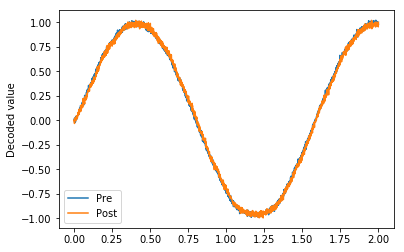

In [32]:
plot(sim.trange(), sim.data[pre_p], label="Pre")
plot(sim.trange(), sim.data[post_p], label="Post")
ylabel("Decoded value")
legend(loc="best");

In [33]:
conn.learning_rule_type = nengo.BCM(learning_rate=5e-10)

with model:
    trans_p = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.01)

sim = nengo.Simulator(model)
sim.run(20.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

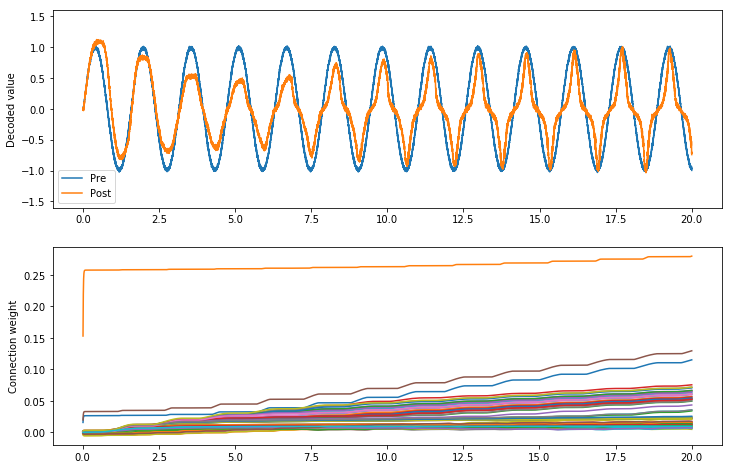

In [39]:
figure(figsize=(12, 8))
subplot(2, 1, 1)
plot(sim.trange(), sim.data[pre_p], label="Pre")
plot(sim.trange(), sim.data[post_p], label="Post")
ylabel("Decoded value")
ylim(-1.6, 1.6)
legend(loc="lower left")

subplot(2, 1, 2)
# Find weight row with max variance
neuron = np.argmax(np.mean(np.var(sim.data[trans_p], axis=0), axis=1))
plot(sim.trange(dt=0.01), sim.data[trans_p][..., neuron])
ylabel("Connection weight");

In [48]:
def sparsity_measure(vector):
    # Max sparsity = 1 (single 1 in the vector)
    v = np.sort(np.abs(vector))
    n = v.shape[0]
    k = np.arange(n) + 1
    l1norm = np.sum(v)
    summation = np.sum((v / l1norm) * ((n - k + 0.5) / n))
    return 1 - 2 * summation

print("Starting sparsity: {0}".format(sparsity_measure(sim.data[trans_p][0])))
print("Ending sparsity: {0}".format(sparsity_measure(sim.data[trans_p][-1])))

ERROR:nengo_gui.server:Error response
Traceback (most recent call last):
  File "/Users/celiasmi/Documents/nengo/nengo_gui/nengo_gui/server.py", line 412, in do_GET
    self.http_GET()
  File "/Users/celiasmi/Documents/nengo/nengo_gui/nengo_gui/guibackend.py", line 137, in http_GET
    server.HttpWsRequestHandler.http_GET(self)
  File "/Users/celiasmi/Documents/nengo/nengo_gui/nengo_gui/server.py", line 428, in http_GET
    response = getattr(self, command)()
  File "/Users/celiasmi/Documents/nengo/nengo_gui/nengo_gui/guibackend.py", line 86, in auth_checked
    return fn(inst)
  File "/Users/celiasmi/Documents/nengo/nengo_gui/nengo_gui/guibackend.py", line 233, in serve_main
    page = self.server.create_page(filename, reset_cfg=reset_cfg)
  File "/Users/celiasmi/Documents/nengo/nengo_gui/nengo_gui/guibackend.py", line 457, in create_page
    reset_cfg=reset_cfg)
  File "/Users/celiasmi/Documents/nengo/nengo_gui/nengo_gui/page.py", line 114, in __init__
    self.load()
  File "/Users/

- Result: only a few neurons will fire
    - Sparsification
- What would this do in NEF terms?        
    - Still represent $x$, but with very sparse encoders (assuming the function doesn't change)
- This is still a rule on the weight matrix, but functionally seems to be more about encoders than decoders
    - What could we do, given that?  

## The homeostatic Prescribed Error Sensitivity (hPES) rule

- Just do them both [(Bekolay et al., 2013)](http://compneuro.uwaterloo.ca/publications/bekolay2013.html)
- And have a parameter $S$ to adjust how much of each

$\Delta \omega_{ij} = \kappa a_i (\alpha_j S e_j \cdot E + (1-S) a_j (a_j-\theta))$

- Works as well (or better) than PES
    - Seems to be a bit more stable, but analysis is ongoing
- Biological evidence?
    - Spike-Timing Dependent Plasticity

<img src="files/lecture_learning/STDP.png" width="500">

<img src="files/lecture_learning/STDP2.png" width="500">

- Still work to do for comparison, but seems promising
- Error-driven for improving decoders
- Hebbian sparsification to improve encoders
    - Perhaps to sparsify connections (energy savings in the brain, but not necessarily in simulation)
    
